<a href="https://colab.research.google.com/github/anirudh-chakravarthy/IR-Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IR Assignment

Implementation of **Fake News Detection on Social Media using Geometric Deep Learning**.

Group 14:
1. Anirudh Srinivasan Chakravarthy - 2017A7TS1195P
2. Pradhit Ongole - 2017A3PS0188P
3. Yashaswi Pandey - 2017B5A70971P
4. Roshan Roy - 2017A7TS1172P
5. Divyam Goel - 2017A7TS1196P


## References
1. https://github.com/KMint1819/SociaMedia/blob/ba2cca9e416461ae9916a0388cccf498b5b3ae57/hw3_gnn/Copy_of_Graph_Neural_Networks.ipynb
2. https://github.com/YingtongDou/GCNN
3. https://chrsmrrs.github.io/datasets/docs/datasets/

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/Academics/IR-Assignment/

/content/gdrive/MyDrive/Academics/IR-Assignment


## Requirements

In [ ]:
!pip install torch==1.7.0 torchvision==0.8.0 torchaudio==0.7.0

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html
!pip install torch-geometric

## Imports

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch.optim import Adam
from torch.utils.data import random_split
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GATConv, global_mean_pool

from sklearn.metrics import (f1_score, accuracy_score, recall_score, 
                             precision_score, roc_curve, roc_auc_score)
import pdb

import matplotlib.pyplot as plt
%matplotlib inline

# hyper-parameters
BATCH_SIZE = 128
LR = 1e-3
NUM_EPOCHS = 1000
SEED = 42

# for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Network Architecture

In [ ]:
# implementation of https://arxiv.org/abs/1902.06673
class GeometricNet(nn.Module):
  def __init__(self, 
               conv_in_layers,
               conv_out_layers=64,
               num_classes=2):
    super(GeometricNet, self).__init__()

    assert conv_out_layers % 2 == 0, 'Convolution output should have even number of layers'
    fc_out_layers = conv_out_layers//2

    self.conv1 = GATConv(conv_in_layers, conv_out_layers)
    self.conv2 = GATConv(conv_out_layers, conv_out_layers)
    self.fc1 = Linear(conv_out_layers, fc_out_layers)
    self.fc2 = Linear(fc_out_layers, num_classes)

    self.activation = nn.SELU(inplace=True)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    if data.num_node_features == 0:
      x = torch.ones(data.num_nodes, 1, device=torch.cuda.current_device())

    x = self.conv1(x, edge_index)
    x = self.activation(x)
    x = self.conv2(x, edge_index)
    x = self.activation(x)
    x = global_mean_pool(x, batch)
    x = self.activation(x)
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    return x

# evaluation metrics
def test(model, loader):
  acc, f1, precision, recall = 0., 0., 0., 0.
  model.eval()

  for i, data in enumerate(loader):
    y = data.y.cpu().numpy()
    data = data.to(torch.cuda.current_device())
    pred = model(data)
    y_pred = F.softmax(pred, dim=-1).argmax(dim=1).cpu().numpy()
    acc += accuracy_score(y, y_pred)
    f1 += f1_score(y, y_pred, average='macro')
    precision += precision_score(y, y_pred, zero_division=0)
    recall += recall_score(y, y_pred, zero_division=0)

  acc /= len(test_loader)
  f1 /= len(test_loader)
  precision /= len(test_loader)
  recall /= len(test_loader)
  return acc, f1, precision, recall

## Training

In [ ]:
# 3 datasets tested: AIDS, PROTEINS, SYNTHETIC
# dataset = TUDataset(root='data/', name='AIDS', use_node_attr=True)
# dataset = TUDataset(root='data/', name='PROTEINS', use_node_attr=True)
dataset = TUDataset(root='data/', name='SYNTHETIC', use_node_attr=True)

# random 80-20 split for training and test loader
num_training = int(len(dataset) * 0.8)
num_test = len(dataset) - num_training
training_set, test_set = random_split(dataset, [num_training, num_test], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# instantiate model, optimizer, and hinge-loss
model = GeometricNet(max(dataset.num_node_features, 1), 
                     num_classes=dataset.num_classes).to(torch.cuda.current_device())
optimizer = Adam(model.parameters(), lr=LR)
loss_fn = nn.MultiMarginLoss() # nn.CrossEntropyLoss()

# training loop
for epoch in range(NUM_EPOCHS):
  model.train()
  for i, data in enumerate(train_loader):
    data = data.to(torch.cuda.current_device())
    pred = model(data)
    loss = loss_fn(pred, data.y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # print evaluation stats every 10 epochs
  if epoch % 10 == 0:
    acc, f1, precision, recall = test(model, test_loader)
    print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}, F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
        epoch, loss, acc, f1, precision, recall))

Epoch 0. Loss: 0.5006. Test accuracy: 0.4333, F1: 0.3023, Precision: 0.0000, Recall: 0.0000
Epoch 10. Loss: 0.4710. Test accuracy: 0.4333, F1: 0.3023, Precision: 0.0000, Recall: 0.0000
Epoch 20. Loss: 0.4774. Test accuracy: 0.4333, F1: 0.3023, Precision: 0.0000, Recall: 0.0000
Epoch 30. Loss: 0.4374. Test accuracy: 0.5333, F1: 0.5200, Precision: 0.6875, Recall: 0.3235
Epoch 40. Loss: 0.3981. Test accuracy: 0.6833, F1: 0.6760, Precision: 0.7143, Recall: 0.7353
Epoch 50. Loss: 0.3473. Test accuracy: 0.7333, F1: 0.7222, Precision: 0.7368, Recall: 0.8235
Epoch 60. Loss: 0.2736. Test accuracy: 0.7833, F1: 0.7818, Precision: 0.8387, Recall: 0.7647
Epoch 70. Loss: 0.2929. Test accuracy: 0.7833, F1: 0.7644, Precision: 0.7442, Recall: 0.9412
Epoch 80. Loss: 0.1968. Test accuracy: 0.7500, F1: 0.7499, Precision: 0.8519, Recall: 0.6765
Epoch 90. Loss: 0.2165. Test accuracy: 0.8167, F1: 0.8141, Precision: 0.8485, Recall: 0.8235
Epoch 100. Loss: 0.1757. Test accuracy: 0.8333, F1: 0.8316, Precision: 

## ROC curve and AUC 

In [ ]:
gt, probs = [], []
model.eval()
for i, data in enumerate(test_loader):
    y = data.y.cpu().numpy()
    gt.extend(y)
    data = data.to(torch.cuda.current_device())
    pred = model(data)
    prob = F.softmax(pred, dim=-1)[:, 1].detach().cpu().numpy() # class label
    probs.extend(prob)

In [ ]:
auc = roc_auc_score(np.array(gt), np.array(probs))
print(auc)

0.9909502262443438


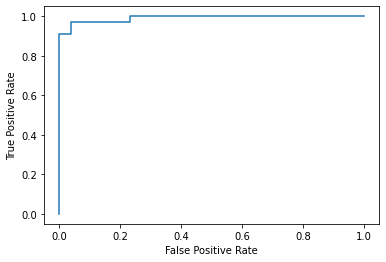

In [ ]:
fpr, tpr, _ = roc_curve(np.array(gt), np.array(probs))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()